<a href="https://colab.research.google.com/github/prithi555/Credit-Card-/blob/main/major_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# FILE 1: SETUP AND DATA LOADING
# Credit Card Approval Prediction - Part 1
# Install required packages
!pip install scikit-learn pandas numpy matplotlib seaborn imbalanced-learn xgboost -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

# LOAD DATASET

# Load from UCI Repository (Credit Approval dataset)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"

# Column names for the dataset
columns = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
           'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']

try:
    df = pd.read_csv(url, names=columns, na_values='?')
    print("✓ Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())
except:
    print("⚠ Could not load dataset from URL. Please upload manually.")
    # Alternative: Upload from local
    # from google.colab import files
    # uploaded = files.upload()
    # df = pd.read_csv(list(uploaded.keys())[0])

print("\n✓ FILE 1 COMPLETED - Dataset loaded and ready!")
print("Next: Run FILE 2 for Data Exploration")


✓ All libraries imported successfully!
✓ Dataset loaded successfully!
Dataset shape: (690, 16)

First few rows:
  A1     A2     A3 A4 A5 A6 A7    A8 A9 A10  A11 A12 A13    A14  A15 A16
0  b  30.83  0.000  u  g  w  v  1.25  t   t    1   f   g  202.0    0   +
1  a  58.67  4.460  u  g  q  h  3.04  t   t    6   f   g   43.0  560   +
2  a  24.50  0.500  u  g  q  h  1.50  t   f    0   f   g  280.0  824   +
3  b  27.83  1.540  u  g  w  v  3.75  t   t    5   t   g  100.0    3   +
4  b  20.17  5.625  u  g  w  v  1.71  t   f    0   f   s  120.0    0   +

✓ FILE 1 COMPLETED - Dataset loaded and ready!
Next: Run FILE 2 for Data Exploration


DATA EXPLORATION

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      678 non-null    object 
 1   A2      678 non-null    float64
 2   A3      690 non-null    float64
 3   A4      684 non-null    object 
 4   A5      684 non-null    object 
 5   A6      681 non-null    object 
 6   A7      681 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 non-null    object 
 9   A10     690 non-null    object 
 10  A11     690 non-null    int64  
 11  A12     690 non-null    object 
 12  A13     690 non-null    object 
 13  A14     677 non-null    float64
 14  A15     690 non-null    int64  
 15  A16     690 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB
None

Dataset Statistics:
               A2          A3          A8        A11          A14  \
count  678.000000  690.000000  690.000

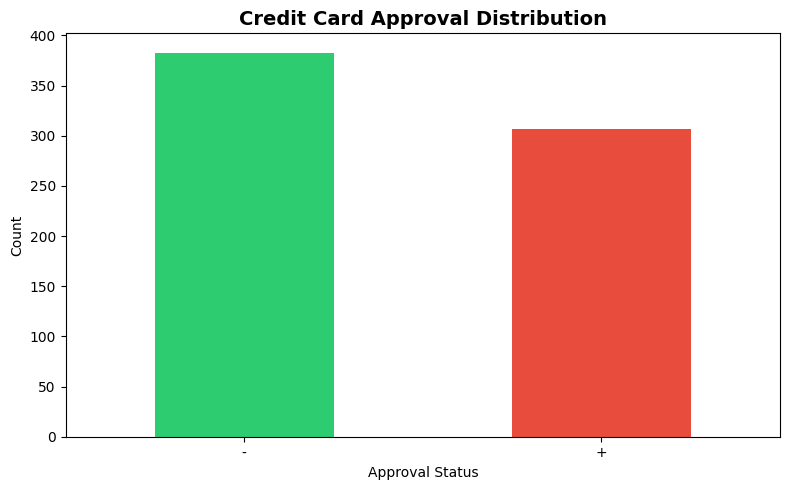

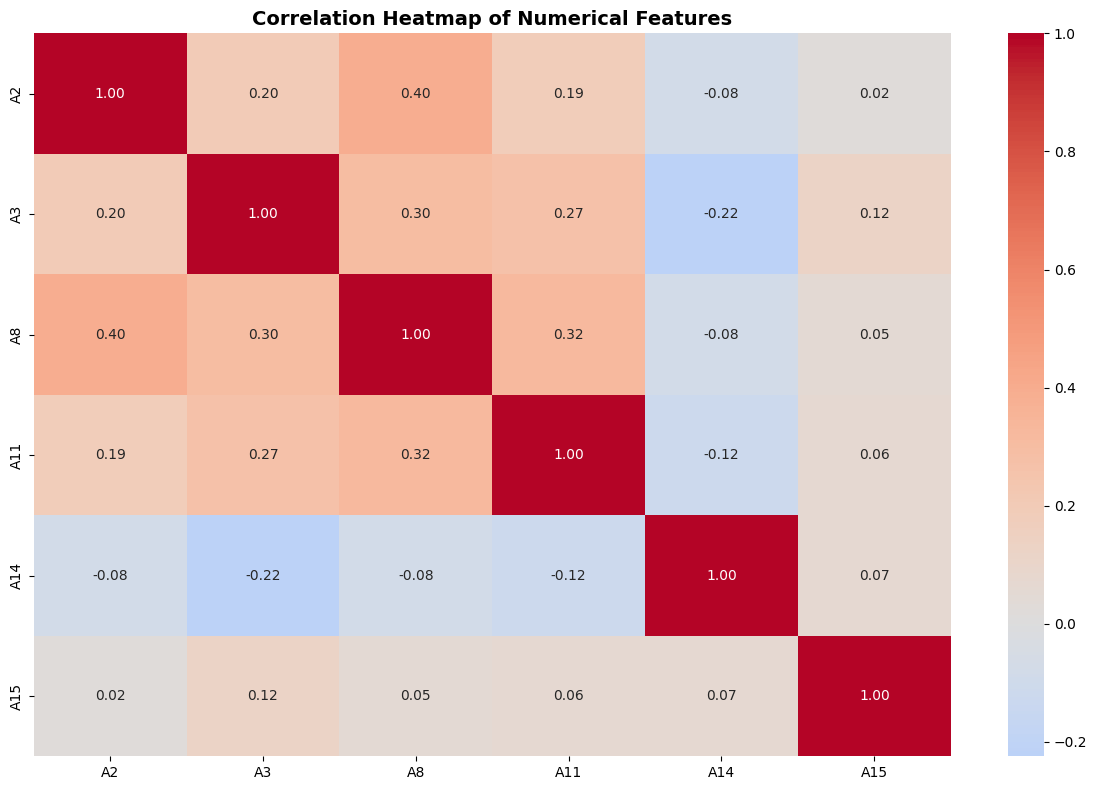


✓ FILE 2 COMPLETED - Data exploration finished!
Next: Run FILE 3 for Data Preprocessing


In [ ]:
# FILE 2: DATA EXPLORATION
# Credit Card Approval Prediction - Part 2

print("="*70)
print("DATA EXPLORATION")
print("="*70)

# Basic information
print("\nDataset Info:")
print(df.info())

print("\nDataset Statistics:")
print(df.describe())

print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print("\nTarget Variable Distribution:")
print(df['A16'].value_counts())

# Visualize target distribution
plt.figure(figsize=(8, 5))
df['A16'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Credit Card Approval Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Approval Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Heatmap of Numerical Features', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

print("\n✓ FILE 2 COMPLETED - Data exploration finished!")
print("Next: Run FILE 3 for Data Preprocessing")


In [ ]:
# STEP 4: Data Preprocessing

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values
print("\nHandling missing values...")
for col in df_processed.columns:
    if df_processed[col].dtype == 'object':
        # Fill categorical with mode
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    else:
        # Fill numerical with median
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

print("✓ Missing values handled")

# Encode categorical variables
print("\nEncoding categorical variables...")
label_encoders = {}
for col in df_processed.columns:
    if df_processed[col].dtype == 'object':
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le

print("✓ Categorical encoding completed")

# Separate features and target
X = df_processed.drop('A16', axis=1)
y = df_processed['A16']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("✓ Feature scaling completed")




DATA PREPROCESSING

Handling missing values...
✓ Missing values handled

Encoding categorical variables...
✓ Categorical encoding completed

Features shape: (690, 15)
Target shape: (690,)
✓ Feature scaling completed


In [ ]:
# STEP 5: Handle Class Imbalance with SMOTE

print("\n" + "="*70)
print("HANDLING CLASS IMBALANCE")
print("="*70)

print(f"\nOriginal class distribution:")
print(y.value_counts())

# Split data first
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())
print("✓ SMOTE applied successfully")



HANDLING CLASS IMBALANCE

Original class distribution:
A16
1    383
0    307
Name: count, dtype: int64

Balanced class distribution:
A16
1    306
0    306
Name: count, dtype: int64
✓ SMOTE applied successfully


In [ ]:
# STEP 6: Train Multiple Models

print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
}

# Store results
results = {}

print("\nTraining models...\n")
for name, model in models.items():
    print(f"Training {name}...")

    # Train model
    model.fit(X_train_balanced, y_train_balanced)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"  Accuracy: {accuracy:.4f} | ROC-AUC: {roc_auc:.4f}")

print("\n✓ All models trained successfully")




MODEL TRAINING

Training models...

Training Logistic Regression...
  Accuracy: 0.7899 | ROC-AUC: 0.8769
Training Decision Tree...
  Accuracy: 0.8116 | ROC-AUC: 0.8175
Training Random Forest...
  Accuracy: 0.8333 | ROC-AUC: 0.9096
Training Gradient Boosting...
  Accuracy: 0.8043 | ROC-AUC: 0.9025
Training XGBoost...
  Accuracy: 0.8333 | ROC-AUC: 0.9072

✓ All models trained successfully



MODEL COMPARISON

               Model  Accuracy  ROC-AUC
      Random Forest  0.833333 0.909623
            XGBoost  0.833333 0.907175
      Decision Tree  0.811594 0.817543
  Gradient Boosting  0.804348 0.902491
Logistic Regression  0.789855 0.876943


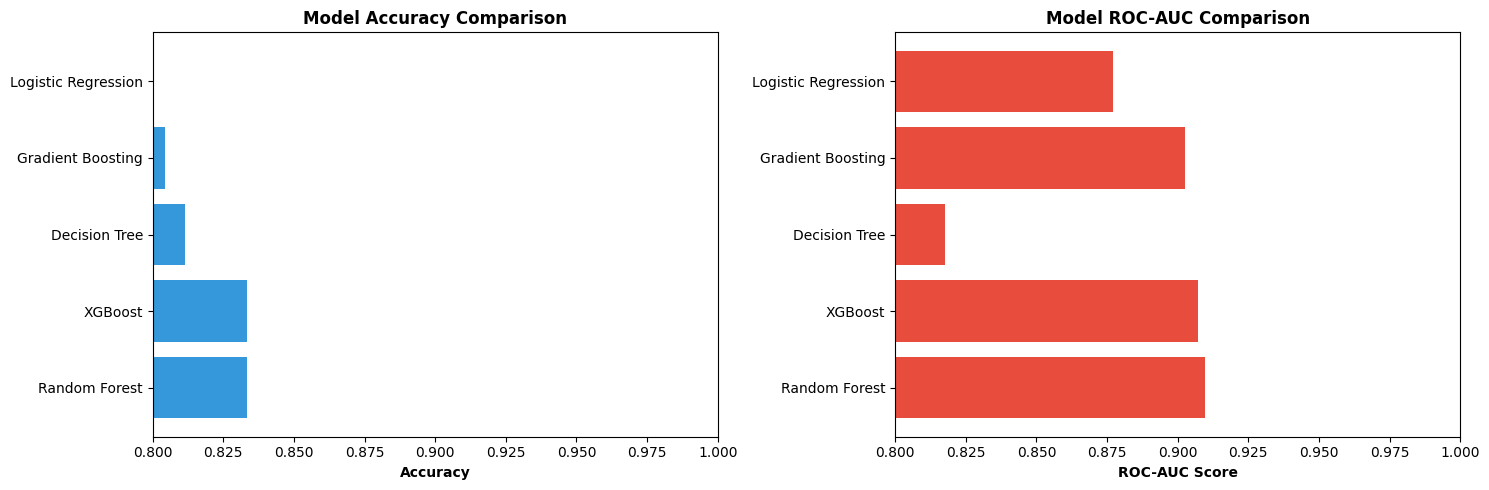

In [ ]:
# STEP 7: Model Comparison

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
axes[0].barh(comparison_df['Model'], comparison_df['Accuracy'], color='#3498db')
axes[0].set_xlabel('Accuracy', fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].set_xlim([0.8, 1.0])

# ROC-AUC comparison
axes[1].barh(comparison_df['Model'], comparison_df['ROC-AUC'], color='#e74c3c')
axes[1].set_xlabel('ROC-AUC Score', fontweight='bold')
axes[1].set_title('Model ROC-AUC Comparison', fontweight='bold')
axes[1].set_xlim([0.8, 1.0])

plt.tight_layout()
plt.show()




DETAILED ANALYSIS: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        61
           1       0.86      0.83      0.85        77

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138



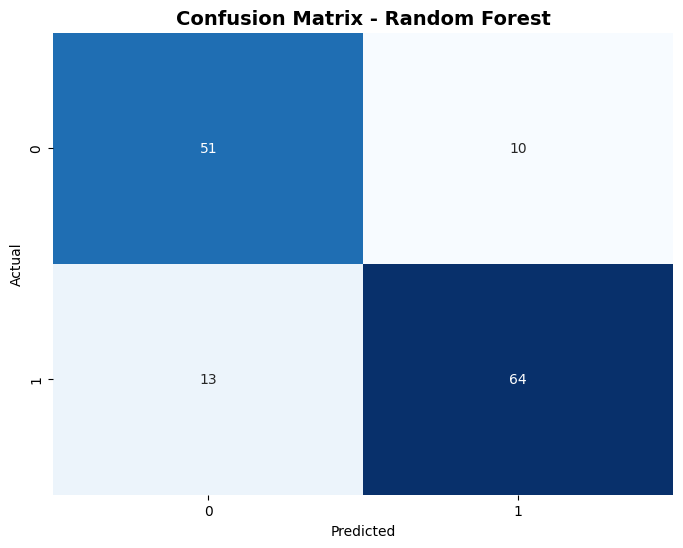

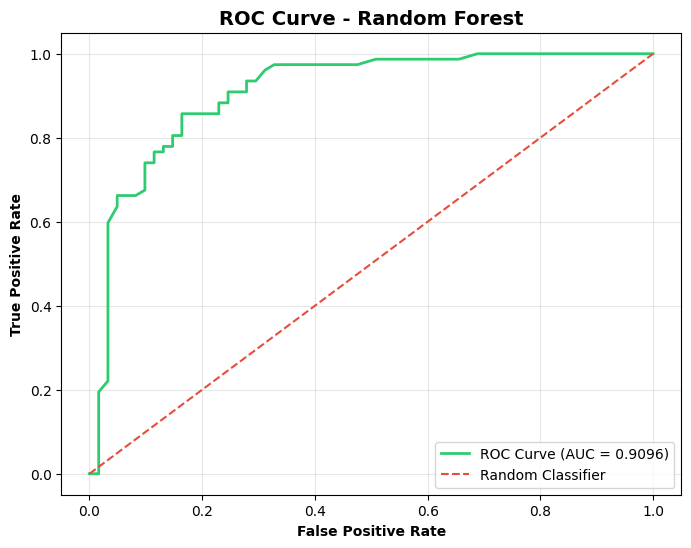


Top 10 Most Important Features:
Feature  Importance
     A9    0.351722
    A11    0.085759
     A8    0.078923
     A3    0.076771
    A15    0.075537
     A2    0.072637
    A10    0.059463
    A14    0.058739
     A6    0.055986
     A7    0.027772


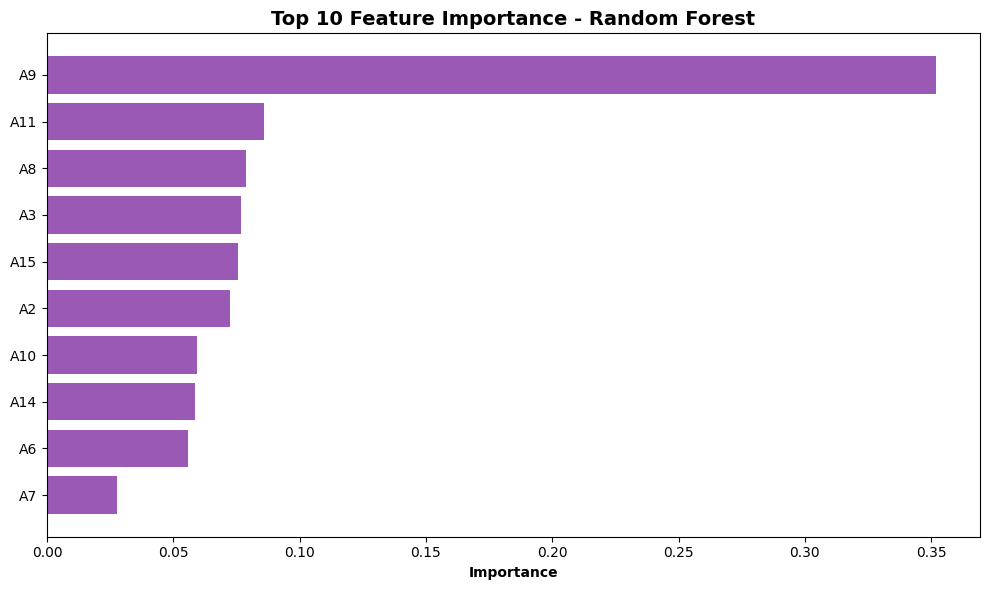

In [ ]:
# STEP 8: Detailed Analysis of Best Model

best_model_name = comparison_df.iloc[0]['Model']
best_model_results = results[best_model_name]

print("\n" + "="*70)
print(f"DETAILED ANALYSIS: {best_model_name}")
print("="*70)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, best_model_results['y_pred']))

# Confusion Matrix
cm = confusion_matrix(y_test, best_model_results['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_model_results['y_pred_proba'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#2ecc71', linewidth=2, label=f'ROC Curve (AUC = {best_model_results["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='#e74c3c', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title(f'ROC Curve - {best_model_name}', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Feature Importance (if applicable)
if hasattr(best_model_results['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model_results['model'].feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10), color='#9b59b6')
    plt.xlabel('Importance', fontweight='bold')
    plt.title(f'Top 10 Feature Importance - {best_model_name}', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



In [ ]:
# ============================================================================
# FILE 9: SAVE MODEL AND ARTIFACTS (STANDALONE VERSION)
# Credit Card Approval Prediction - Part 9
# ============================================================================

import pickle
from datetime import datetime

print("="*70)
print("MODEL SAVING")
print("="*70)

# Check if required variables exist
required_vars = ['results', 'scaler', 'label_encoders', 'X', 'X_train_balanced', 'X_test']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"❌ ERROR: Missing variables: {', '.join(missing_vars)}")
    print("\n⚠️  You need to run Files 1-8 first in the same session!")
    print("\n💡 SOLUTION: Run all files in order without restarting runtime:")
    print("   File 1 → File 2 → File 3 → File 4 → File 5 → File 6 → File 7 → File 8 → File 9")
    print("\n   OR create a single notebook with all code combined.")
else:
    # Find best model from results
    best_accuracy = 0
    best_model_name = None
    best_model_results = None

    for name, result in results.items():
        if result['accuracy'] > best_accuracy:
            best_accuracy = result['accuracy']
            best_model_name = name
            best_model_results = result

    print(f"✓ Best model identified: {best_model_name}")

    # Create timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save the best model
    model_filename = f'credit_approval_model_{best_model_name.replace(" ", "_")}_{timestamp}.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(best_model_results['model'], file)
    print(f"✓ Model saved as '{model_filename}'")

    # Save the scaler
    scaler_filename = f'scaler_{timestamp}.pkl'
    with open(scaler_filename, 'wb') as file:
        pickle.dump(scaler, file)
    print(f"✓ Scaler saved as '{scaler_filename}'")

    # Save label encoders
    encoders_filename = f'label_encoders_{timestamp}.pkl'
    with open(encoders_filename, 'wb') as file:
        pickle.dump(label_encoders, file)
    print(f"✓ Label encoders saved as '{encoders_filename}'")

    # Save feature names
    feature_names_filename = f'feature_names_{timestamp}.pkl'
    with open(feature_names_filename, 'wb') as file:
        pickle.dump(list(X.columns), file)
    print(f"✓ Feature names saved as '{feature_names_filename}'")

    # Save model performance metrics
    metrics = {
        'model_name': best_model_name,
        'accuracy': best_model_results['accuracy'],
        'roc_auc': best_model_results['roc_auc'],
        'timestamp': timestamp
    }
    metrics_filename = f'model_metrics_{timestamp}.pkl'
    with open(metrics_filename, 'wb') as file:
        pickle.dump(metrics, file)
    print(f"✓ Model metrics saved as '{metrics_filename}'")

    # Create a summary report
    print("\n" + "="*70)
    print("MODEL SUMMARY REPORT")
    print("="*70)
    print(f"\nBest Model: {best_model_name}")
    print(f"Accuracy: {best_model_results['accuracy']:.4f}")
    print(f"ROC-AUC Score: {best_model_results['roc_auc']:.4f}")
    print(f"Training Samples: {X_train_balanced.shape[0]}")
    print(f"Test Samples: {X_test.shape[0]}")
    print(f"Number of Features: {X.shape[1]}")
    print(f"\nSaved Files:")
    print(f"  - {model_filename}")
    print(f"  - {scaler_filename}")
    print(f"  - {encoders_filename}")
    print(f"  - {feature_names_filename}")
    print(f"  - {metrics_filename}")

    # Example: How to load the model later
    print("\n" + "="*70)
    print("HOW TO LOAD THE MODEL LATER")
    print("="*70)
    print("""
# Load the saved model
with open('""" + model_filename + """', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the scaler
with open('""" + scaler_filename + """', 'rb') as file:
    loaded_scaler = pickle.load(file)

# Make predictions with loaded model
# new_data = [[...]]  # Your new data (2D array)
# scaled_data = loaded_scaler.transform(new_data)
# prediction = loaded_model.predict(scaled_data)
""")

    # Download files (for Google Colab)
    print("\n" + "="*70)
    print("DOWNLOAD FILES (Google Colab)")
    print("="*70)
    print("To download files, run this code in a new cell:")
    print("""
from google.colab import files

# Download all saved files
files.download('""" + model_filename + """')
files.download('""" + scaler_filename + """')
files.download('""" + encoders_filename + """')
files.download('""" + feature_names_filename + """')
files.download('""" + metrics_filename + """')
""")

    print("\n✓ FILE 9 COMPLETED - All models and artifacts saved!")
    print("\n" + "="*70)
    print("🎉 PROJECT COMPLETED SUCCESSFULLY! 🎉")
    print("="*70)
    print("\nAll 9 files have been executed successfully!")
    print("Your credit card approval prediction system is ready to use!")


MODEL SAVING
✓ Best model identified: Random Forest
✓ Model saved as 'credit_approval_model_Random_Forest_20251122_143017.pkl'
✓ Scaler saved as 'scaler_20251122_143017.pkl'
✓ Label encoders saved as 'label_encoders_20251122_143017.pkl'
✓ Feature names saved as 'feature_names_20251122_143017.pkl'
✓ Model metrics saved as 'model_metrics_20251122_143017.pkl'

MODEL SUMMARY REPORT

Best Model: Random Forest
Accuracy: 0.8333
ROC-AUC Score: 0.9096
Training Samples: 612
Test Samples: 138
Number of Features: 15

Saved Files:
  - credit_approval_model_Random_Forest_20251122_143017.pkl
  - scaler_20251122_143017.pkl
  - label_encoders_20251122_143017.pkl
  - feature_names_20251122_143017.pkl
  - model_metrics_20251122_143017.pkl

HOW TO LOAD THE MODEL LATER

# Load the saved model
with open('credit_approval_model_Random_Forest_20251122_143017.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the scaler
with open('scaler_20251122_143017.pkl', 'rb') as file:
    loaded_scaler = pi

In [ ]:
# STEP 10: Save Model (Optional)

import pickle

# Save the best model
model_filename = f'best_model_{best_model_name.replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model_results['model'], file)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print(f"\n✓ Model saved as '{model_filename}'")
print(f"✓ Scaler saved as 'scaler.pkl'")

print("\n" + "="*70)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*70)



✓ Model saved as 'best_model_Random_Forest.pkl'
✓ Scaler saved as 'scaler.pkl'

PROJECT COMPLETED SUCCESSFULLY!
